# Burgers equation

This code is modified from the code https://github.com/alexpapados/Physics-Informed-Deep-Learning-Solid-and-Fluid-Mechanics

The paper about this work can ref https://www.researchgate.net/publication/359480166_Discontinuity_Computing_with_Physics-Informed_Neural_Network

In [89]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
import math
#import matplotlib

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
  #  random.seed(seed)
    torch.backends.cudnn.deterministic = True
    
setup_seed(124)

In [107]:
def train(epoch):
    model.train()
    model.it = epoch
    def closure():
        optimizer.zero_grad()                                              
        loss_pde = model.loss_pde(x_int)                                   
        loss_ic = model.loss_ic(x_ic, u_ic)  
        loss = loss_pde + 10*loss_ic                                       

        print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f}')
        #model.it = model.it + 1
        #outputfile = open('loss_history_burgers.dat','a+')
        #print(f'{model.it}  {loss_pde:.6f}  {loss_ic:.6f}  {loss:.6f}',file=outputfile)
        #outputfile.close() 
        loss.backward()
        return loss

    loss = optimizer.step(closure)
    loss_value = loss.item() if not isinstance(loss, float) else loss
    print(f'epoch {epoch}: loss {loss_value:.6f}')
    
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

def IC(x):
    N = len(x)
    u_init = np.zeros((x.shape[0]))                                                
    for i in range(N):
        u_init[i] = -np.sin(np.pi*(x[i,1]-1))
    return u_init

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()                                                  
        self.net.add_module('Linear_layer_1', nn.Linear(2, 30))                     
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              

        for num in range(2, 4):                                                     
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(30, 30))       
            self.net.add_module('Tanh_layer_%d' % (num), nn.Tanh())                 
        self.net.add_module('Linear_layer_final', nn.Linear(30, 1))                 

    def forward(self, x):
        return self.net(x)

    def loss_pde(self, x):
        y = self.net(x)                                                
        u = y[:, 0:1]
        
        U = u**2/2

        dU_g = gradients(U, x)[0]                                  
        U_x = dU_g[:, 1:]
        du_g = gradients(u, x)[0]                                 
        u_t,u_x = du_g[:, :1],du_g[:,1:]
        d = 0.1*(abs(u_x)-u_x) + 1
        #d = 1
        
        f = (((u_t + U_x)/d)**2).mean() 
         
        return f
    def res_pde(self,x):
        y = self.net(x)
        Res = np.zeros((x.shape[0]))                                  
        
        u = y[:, 0:1]
        U = u**2/2
        dU_g = gradients(U, x)[0]                                 
        U_x = dU_g[:, 1:]
        du_g = gradients(u, x)[0]                                  
        u_t,u_x = du_g[:, :1],du_g[:,1:]
        Res = (u_t + U_x)**2 
        return Res 
    
    def lambda_pde(self,x):
        y = self.net(x)
        Res = np.zeros((x.shape[0]))                                  
        
        u = y[:, 0:1]
        du_g = gradients(u, x)[0]                                  
        u_t,u_x = du_g[:, :1],du_g[:,1:]
        d = 0.1*(abs(u_x)-u_x) + 1
        return  d
        

    def loss_ic(self, x_ic, u_ic):
        y_ic = self.net(x_ic)                                                      
        u_ic_nn = y_ic[:, 0]
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean()
        return loss_ics

In [110]:

device = torch.device('cuda')                                      
#device = torch.device('cpu')                                      
num_x = 101                                                        
num_t = 101                                                        
num_i_train = 101                                          
num_f_train =  101*101                                         
x = np.linspace(0, 2, num_x)                                   
t = np.linspace(0, 1, num_t)                                   
t_grid, x_grid = np.meshgrid(t, x)                             
T = t_grid.flatten()[:, None]                                  
X = x_grid.flatten()[:, None]                                  

id_ic = np.random.choice(num_x, num_i_train, replace=False)    
id_f = np.random.choice(num_x*num_t, num_f_train, replace=False)

x_ic = x_grid[id_ic, 0][:, None]                               
t_ic = t_grid[id_ic, 0][:, None]                               
x_ic_train = np.hstack((t_ic, x_ic))                               
u_ic_train = IC(x_ic_train)                 

x_int = X[:, 0][id_f, None]                                        
t_int = T[:, 0][id_f, None]                                        
x_int_train = np.hstack((t_int, x_int))                            

u_ic_train = IC(x_ic_train)                 

x_ic = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
x_int = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)
u_ic = torch.tensor(u_ic_train, dtype=torch.float32).to(device)

model = DNN().to(device)

lr = 0.001

In [109]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.LBFGS(model.parameters(), lr=1.1, 
#                              max_iter = 25, 
#                              max_eval = None, 
#                              tolerance_grad = 1e-05, 
#                              tolerance_change = 1e-09, 
#                              history_size = 100, 
#                              line_search_fn = 'strong_wolfe')
epochs = 15000
tic = time.time()
for epoch in range(1, epochs+1):
    train(epoch)
    
toc = time.time()

epoch 1 loss_pde:0.00473107, loss_ic:0.54928607
epoch 1: loss 5.497592
epoch 2 loss_pde:0.00353290, loss_ic:0.53271151
epoch 2: loss 5.330648
epoch 3 loss_pde:0.00268663, loss_ic:0.51827127
epoch 3: loss 5.185399
epoch 4 loss_pde:0.00208776, loss_ic:0.50515085
epoch 4: loss 5.053596
epoch 5 loss_pde:0.00163662, loss_ic:0.49281445
epoch 5: loss 4.929781
epoch 6 loss_pde:0.00128706, loss_ic:0.48098519
epoch 6: loss 4.811139
epoch 7 loss_pde:0.00102499, loss_ic:0.46948400
epoch 7: loss 4.695865
epoch 8 loss_pde:0.00084027, loss_ic:0.45819053
epoch 8: loss 4.582746
epoch 9 loss_pde:0.00073112, loss_ic:0.44702798
epoch 9: loss 4.471011
epoch 10 loss_pde:0.00070170, loss_ic:0.43594947
epoch 10: loss 4.360197
epoch 11 loss_pde:0.00076010, loss_ic:0.42492449
epoch 11: loss 4.250005
epoch 12 loss_pde:0.00091703, loss_ic:0.41392910
epoch 12: loss 4.140208
epoch 13 loss_pde:0.00118575, loss_ic:0.40294114
epoch 13: loss 4.030597
epoch 14 loss_pde:0.00158242, loss_ic:0.39193800
epoch 14: loss 3.920

KeyboardInterrupt: 

In [111]:
optimizer = torch.optim.LBFGS(model.parameters(),lr=1.0,max_iter=20)
#optimizer = torch.optim.LBFGS(model.parameters(), lr=1.1, 
#                              max_iter = 25, 
#                              max_eval = None, 
#                              tolerance_grad = 1e-05, 
#                              tolerance_change = 1e-09, 
#                              history_size = 100, 
#                              line_search_fn = 'strong_wolfe')
epochs = 2000
tic = time.time()
for epoch in range(1, epochs+1):
    train(epoch)
    
toc = time.time()

epoch 1 loss_pde:0.00029504, loss_ic:0.54029846
epoch 1 loss_pde:0.00020501, loss_ic:0.51835209
epoch 1 loss_pde:0.00561065, loss_ic:0.35042119
epoch 1 loss_pde:0.08365809, loss_ic:0.20232727
epoch 1 loss_pde:0.31560567, loss_ic:0.23675004
epoch 1 loss_pde:0.11852650, loss_ic:0.19172035
epoch 1 loss_pde:0.12826122, loss_ic:0.19003981
epoch 1 loss_pde:0.13695884, loss_ic:0.18854484
epoch 1 loss_pde:0.14654385, loss_ic:0.18627457
epoch 1 loss_pde:0.16483697, loss_ic:0.18061814
epoch 1 loss_pde:0.18072432, loss_ic:0.17078252
epoch 1 loss_pde:0.18341421, loss_ic:0.15904073
epoch 1 loss_pde:0.13150154, loss_ic:0.14327434
epoch 1 loss_pde:2.30494499, loss_ic:2.06086683
epoch 1 loss_pde:0.08567150, loss_ic:0.15262105
epoch 1 loss_pde:0.16021788, loss_ic:0.21068671
epoch 1 loss_pde:0.07328723, loss_ic:0.11818172
epoch 1 loss_pde:0.07086932, loss_ic:0.10279316
epoch 1 loss_pde:1.41538548, loss_ic:0.90816450
epoch 1 loss_pde:0.08678113, loss_ic:0.07261647
epoch 1: loss 5.403280
epoch 2 loss_pde:

Solution found: 0.0048779540435084185
Solution found: 0.009756657101073422
Solution found: 0.01463723269377988
Solution found: 0.01952080434271269
Solution found: 0.024407372047871828
Solution found: 0.029298433837370477
Solution found: 0.03419473872526521
Solution found: 0.039097035725612655
Solution found: 0.04400682286652592
Solution found: 0.04892410014800504
Solution found: 0.05385074010519146
Solution found: 0.058787117245113485
Solution found: 0.063734355088856
Solution found: 0.06869320265047556
Solution found: 0.07366515795808538
Solution found: 0.07865059551871371
Solution found: 0.08365101336047374
Solution found: 0.08866753500445035
Solution found: 0.09370090946470008
Solution found: 0.0987526347693362
Solution found: 0.10382383443944349
Solution found: 0.10891525748907856
Solution found: 0.11402840194635461
Solution found: 0.11916476583938476
Solution found: 0.12432547268925397
Solution found: 0.1295120205240753
Solution found: 0.134725907371962
Solution found: 0.139968256

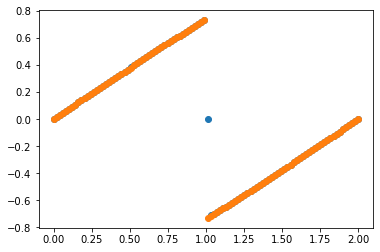

In [104]:
import Exact_burgers
x = np.linspace(0.0, 2.0, 100)                                  
t = np.linspace(1.0, 1.0, 1)                                        
t_grid, x_grid = np.meshgrid(t, x)                              
T = t_grid.flatten()[:, None]                                   
X = x_grid.flatten()[:, None]                                   
x_test = np.hstack((T, X))                                      
x_test = torch.tensor(x_test, requires_grad=True, dtype=torch.float32).to(device)
u_pred = to_numpy(model(x_test))
res = to_numpy(model.res_pde(x_test))
d   = to_numpy(model.lambda_pde(x_test))

y_e = Exact_burgers.Exact_Burgers(x)

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x,u_pred[:,0])
plt.scatter(x,y_e)
#plt.plot(x,ur)

In [105]:
L2 = np.sqrt(np.sum((u_pred[:,0]-y_e)**2)/101)

In [106]:
L2

0.07244251689218993

In [28]:
import numpy
a = numpy.loadtxt('result50WENO.dat')
#a = numpy.loadtxt('WENO100.dat')
a = numpy.loadtxt('WENO200.dat')

In [29]:
a[:,0]

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.

In [30]:
import Exact_burgers

In [31]:
y_e = Exact_burgers.Exact_Burgers(a[:,0])

Solution found: 0.0024144468114010572
Solution found: 0.004829268129830406
Solution found: 0.007244089448259754
Solution found: 0.009659285273717398
Solution found: 0.012074855606203331
Solution found: 0.014491174952745848
Solution found: 0.01690786880631666
Solution found: 0.019325311673944058
Solution found: 0.02174350355562804
Solution found: 0.0241628189583969
Solution found: 0.026583257882250633
Solution found: 0.02900482032718924
Solution found: 0.03142750629321274
Solution found: 0.033851690287349384
Solution found: 0.03627737230959922
Solution found: 0.038704552359962216
Solution found: 0.04113360494546668
Solution found: 0.043564530066112606
Solution found: 0.045997327721899975
Solution found: 0.04843199791282883
Solution found: 0.05086928965295573
Solution found: 0.05330845392822407
Solution found: 0.055749865245662195
Solution found: 0.05819427261932664
Solution found: 0.060640927035160844
Solution found: 0.06309057750722138
Solution found: 0.06554284952847998
Solution found

In [33]:
L2=np.sqrt(np.sum((a[:,1]-y_e)**2)/201)
L2

0.0010470108233288137

In [15]:
import numpy as np

In [22]:
L2

0.0023656853727793566